In [1]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
from ponyslayer.utils import imshow, imshows, imdraw, imdraws, imdraws_color, immask, immasks, implot, imsave
from ponyslayer import unicorn, transform, chessboard_detection
from Kmean_BG_segment import segment

## Parameter Setup

In [2]:
image_resolution = 800 # [pixel] Image ratio can be only 1:1
image_size = 400 # [mm.]
marker_size = 60 # [mm.]
marker_size_error = 0.15 # [ratio] Allowable card size error
min_path_length = 30 # [mm.]
max_path_length = 999 # [mm.]
min_path_width = 5 # [mm.]
max_path_width = marker_size + (marker_size*marker_size_error) # [mm.]
gradient_crop_ratio = 0.9 # Exclude both end (prevent too width range from noise)
min_height = 10
max_height = 20
min_intensity_range = 15 # ช่วงของ intensity ที่แคบที่สุดที่ยังถือว่าเป็น gradient

## Filter Setup

In [3]:
UnsharpMaskBeforeFindMarker = True
BlurKernelSize = (3, 3)

## Load Image

In [4]:
frame = cv2.imread("img/Real6.png")
frame = imutils.resize(frame, height=image_resolution, width = image_resolution)
original = frame.copy()

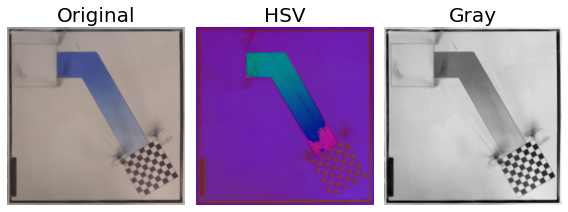

In [5]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.GaussianBlur(gray, BlurKernelSize, 0)
HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
imshows([original, HSV, gray], ["Original", 'HSV', 'Gray'])
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame = cv2.medianBlur(frame,5)
frame = cv2.bilateralFilter(frame,9,75,75)

## Find Destination

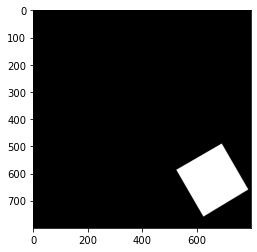

In [6]:
Marker_dst = unicorn.Marker(chessboard_detection.getChessContour(gray)[0])
imshow(immask(Marker_dst.contour, frame))

## Find Path(s)

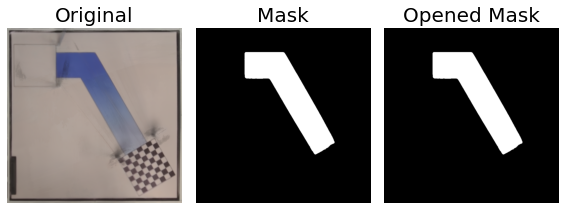

Path count: 1


In [7]:
path_mask = segment(frame, K=3)
kernel = np.ones(BlurKernelSize,np.uint8)
path_mask_opening = cv2.morphologyEx(path_mask, cv2.MORPH_OPEN, kernel)
imshows([original, path_mask, path_mask_opening], ["Original", "Mask", "Opened Mask"])
contours,hierarchy = cv2.findContours(path_mask_opening, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print("Path count: " + str(len(contours)))

## Skeletonize Path(s)

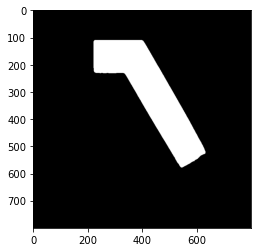

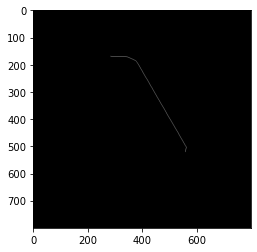

In [8]:
from skimage.morphology import skeletonize
from skimage import data
from skimage.util import invert
from scipy.ndimage import generic_filter

path_masks = [immask(cnt, frame) for cnt in contours]
path_skeletons = []
for i in range(len(path_masks)):
    imshow(path_masks[i])
    skeleton = skeletonize(path_masks[i], method='lee')
    path_skeletons.append(skeleton)
    imshow(skeleton)

Points
[[284 169]
 [285 169]
 [286 169]
 [287 170]
 [288 170]
 [289 170]
 [290 170]
 [291 170]
 [292 170]
 [293 170]
 [294 170]
 [295 170]
 [296 170]
 [297 170]
 [298 170]
 [299 170]
 [300 170]
 [301 170]
 [302 170]
 [303 170]
 [304 170]
 [305 170]
 [306 170]
 [307 170]
 [308 170]
 [309 170]
 [310 170]
 [311 170]
 [312 170]
 [313 170]
 [314 170]
 [315 170]
 [316 170]
 [317 170]
 [318 170]
 [319 170]
 [320 170]
 [321 170]
 [322 170]
 [323 170]
 [324 170]
 [325 170]
 [326 170]
 [327 170]
 [328 170]
 [329 170]
 [330 170]
 [331 170]
 [332 170]
 [333 170]
 [334 170]
 [335 170]
 [336 170]
 [337 170]
 [338 170]
 [339 170]
 [340 170]
 [341 171]
 [342 171]
 [343 171]
 [344 171]
 [345 171]
 [346 172]
 [347 172]
 [348 172]
 [349 173]
 [350 173]
 [351 174]
 [352 174]
 [353 175]
 [354 175]
 [355 175]
 [356 176]
 [357 176]
 [358 177]
 [359 177]
 [360 178]
 [361 178]
 [362 179]
 [363 179]
 [364 179]
 [365 180]
 [366 180]
 [367 181]
 [368 181]
 [369 182]
 [370 182]
 [371 183]
 [372 183]
 [373 184]
 [3

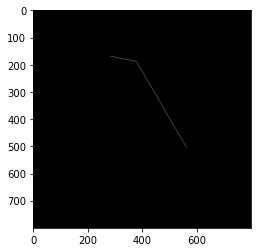

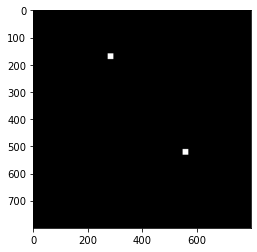

In [9]:
# Line ends filter
def lineEnds(P):
    """Central pixel and just one other must be set to be a line end"""
    return 255 * ((P[4]==255) and np.sum(P)==510)
end_points = []
path_cnts = []
path_cnts_approx = []
for skeleton in path_skeletons:
    points = np.column_stack(np.where(skeleton.transpose() != 0)) # get array of points
    poly_points = cv2.approxPolyDP(points, 0.02 * frame.shape[0], False) # approximate polygon
    poly_canvas = np.zeros_like(original, np.uint8)
    cv2.polylines(poly_canvas, [poly_points], False, (255,255,255), 1)
    imshow(poly_canvas)

    end_of_line = generic_filter(skeleton, lineEnds, (3, 3)) # find end of line
    imshow(cv2.dilate(end_of_line,kernel,iterations = 10))
    end_points.append(np.where(end_of_line==255))
    
    path_cnts.append(points)
    path_cnts_approx.append(poly_points)    

## Generate 2D Waypoints and Extract Gradient

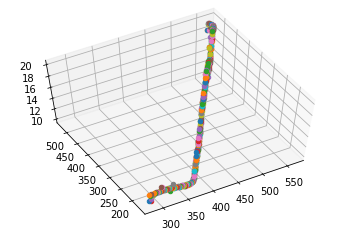

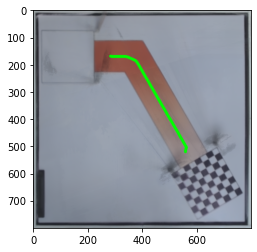

In [10]:
# Visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
visual = []
for path_cnt in path_cnts:
    P = unicorn.Path(path_cnt)
    P.waypoints = path_cnt
    waypoints3D = P.generate_trajectory3D_rev2(src=gray,
                                             min_height=min_height,
                                             max_height=max_height,
                                             gradient_crop_ratio=gradient_crop_ratio,
                                             min_intensity_range=min_intensity_range)
    for waypoint in waypoints3D: ax.scatter(waypoint[0], waypoint[1], waypoint[2])
    canvas = original.copy()
    for i in range(len(path_cnt)): cv2.circle(canvas, (path_cnt[i][0], path_cnt[i][1]), 5, (0, 255, 0), -1)
    visual.append(canvas)
ax.view_init(azim=-120, elev=60)
plt.show()
imshow(visual[0])

In [11]:
H = 30 # Height buffer
waypoints = [] # List of (x, y, z)
for i in range(len(Markers)):
    ### Marker ###
    (x, y) = sorted_object[2*i].center
    waypoints.append((x, y, H)) # Hold height
    if Paths[i].waypoints3D[0][2] == -1: z = H
    else: z = Paths[i].waypoints3D[0][2]
    waypoints.append((x, y, z)) # Adjust height
    H = z # update history
    ### Path ###
    for (x, y, z) in Paths[i].waypoints3D:
#         print(H)
        if z == -1: z = H # Hold height
        waypoints.append((x, y, z))
        H = z # update history
%matplotlib notebook
#%%

fig = plt.figure()
ax = fig.gca(projection='3d')
# for waypoint in waypoints: ax.scatter(waypoint[0], waypoint[1], waypoint[2])
x = [waypoints[i][0] for i in range(len(waypoints))]
y = [waypoints[i][1] for i in range(len(waypoints))]
z = [waypoints[i][2] for i in range(len(waypoints))]
ax.plot(x, y, z)
plt.show()

NameError: name 'Markers' is not defined